# STA314 Final Project Report - YouTube Spam Comments

### Problem Statement

**Relevance and importance**







### Statistical Analyses

#### Exploratory Data Analysis

First, we check the columns of the data loaded:


`Columns: [COMMENT_ID, AUTHOR, DATE, CONTENT, VIDEO_NAME, CLASS]`

where `COMMENT_ID` gives the `ID` from `1` to `1369`. The `AUTHOR` gives the name of the person making the comment. The `DATE` gives the date the comment is made. The `CONTENT` provides the string of the comment. The `VIDEO_NAME` is the video name in which the comment was made on. The `CLASS` is the labelling, where `0` is non-spam, `1` is spam. (I want to give some examples from the data if it's possible to print output)

We can print the first `5` entries from our dataset:

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import seaborn as sns
import nltk
df = pd.read_csv("../Dataset/train.csv")
df_test = pd.read_csv("../Dataset/test.csv")

In [9]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,1,Brandon Pryor,2014-01-19 00:36:25,I dont even watch it anymore i just come here ...,PSY - GANGNAM STYLE(?????) M/V,0
1,2,Chelsea Yun,2015-05-23 07:17:09.691,i hate rap﻿,Eminem - Love The Way You Lie ft. Rihanna,0
2,3,Sofia Aristizabal,2014-09-09 00:43:52,"I loved, she is amazing.. OMG your eyes*_*﻿",Katy Perry - Roar,0
3,4,said abdesalam,2015-05-24 07:35:13.754,song is bad﻿,Eminem - Love The Way You Lie ft. Rihanna,0
4,5,crazy girl,2015-05-23 23:26:05.305,tension⤴︎⤴︎﻿,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",0


Next, we can check out the distribution of the comment lengths:

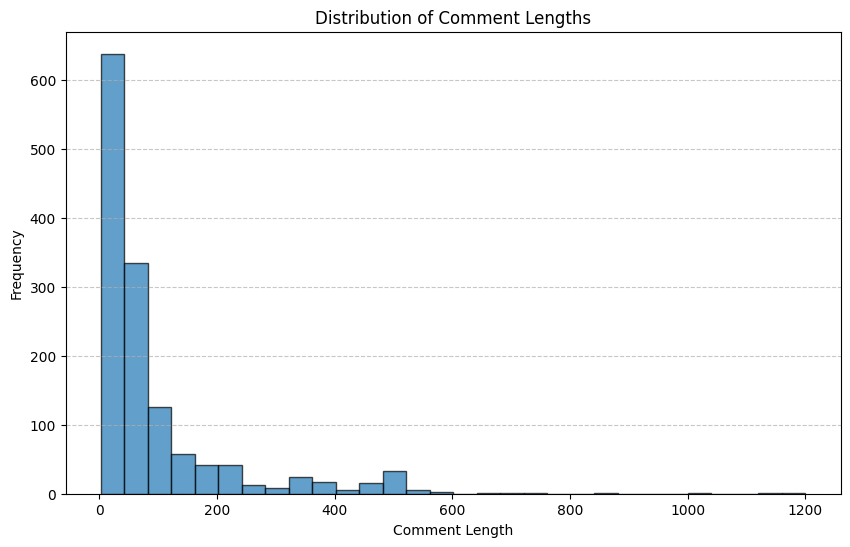

count    1369.000000
mean       95.598977
std       129.375097
min         3.000000
25%        28.000000
50%        48.000000
75%        99.000000
max      1200.000000
Name: Content_Length, dtype: float64


In [10]:
# Add a column for the lengths of the comments
df['Content_Length'] = df['CONTENT'].apply(len)

# Plot the distribution of the lengths
plt.figure(figsize=(10, 6))
plt.hist(df['Content_Length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print stats
print(df['Content_Length'].describe())

We see that the comments range from 3-1200 characters, with the mean around 96 characters. Notice that more than 50% of them are 48 characters or smaller, and 75% of them are under 99 characters.

We can also get the class proportions:

Class Proportions:
CLASS
1    0.518627
0    0.481373
Name: proportion, dtype: float64


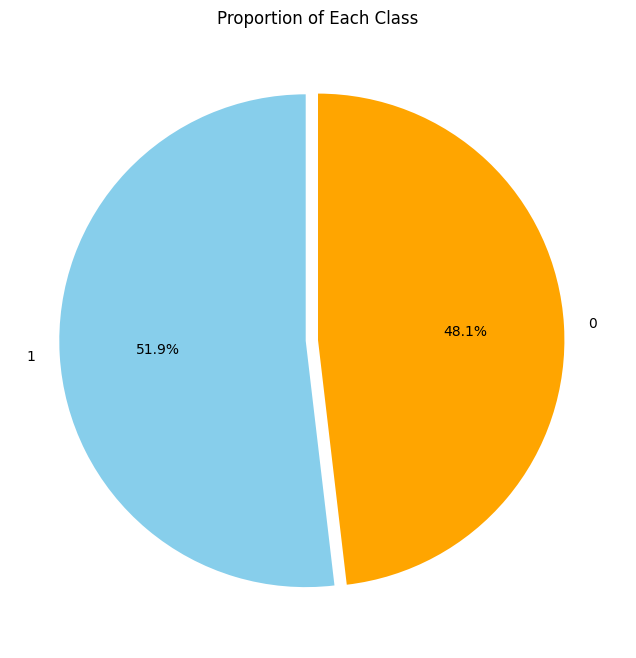

In [24]:
class_proportions = df['CLASS'].value_counts(normalize=True)

# Display the proportions
print("Class Proportions:")
print(class_proportions)

# Plot the proportions
plt.figure(figsize=(8, 8))
class_proportions.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'orange'],
    labels=class_proportions.index,
    explode=[0.05, 0]  # Slightly separate one slice for emphasis
)
plt.title('Proportion of Each Class')
plt.ylabel('')  # Remove the y-label for better appearance
plt.show()

We see that 51.86% fo the data are spam, and 48.14% of the data are not spam. There is no extreme class imbalance.

Next, we can get our most common non-stop words:

In [25]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Ensure you have the stopwords
nltk.download('stopwords')

# Define stop words for filtering
stop_words = set(stopwords.words('english'))

# Tokenize and filter non-stop words
def get_non_stop_words(content):
    # Tokenize the words
    words = content.split()
    # Filter out stop words and non-alphabetic words
    non_stop_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return non_stop_words

# Extract all non-stop words from the dataframe
all_words = []
df['CONTENT'].apply(lambda content: all_words.extend(get_non_stop_words(content)))

# Count the most common words
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Display the most common non-stop words
print("Most Common Non-Stop Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common Non-Stop Words:
check: 383
video: 192
like: 153
please: 137
song: 134
subscribe: 131
love: 130
music: 86
new: 84
channel: 81
guys: 71
get: 69
make: 65
money: 59
people: 59
hey: 54
katy: 52
comment: 49
best: 48
know: 48


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svishwa4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top Words for Class 0:
love: 98
song: 97
like: 48
video: 45
best: 35
katy: 35
billion: 32
views: 31
shakira: 22
people: 21
good: 21
get: 20
perry: 20
years: 19
still: 19
old: 17
party: 14
youtube: 13
music: 13
one: 12

Top Words for Class 1:
check: 377
video: 147
please: 137
subscribe: 131
like: 105
new: 83
channel: 81
music: 73
guys: 70
make: 60
money: 57
hey: 54
get: 49
comment: 44
called: 42
would: 42
thank: 41
people: 38
song: 37
know: 37


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svishwa4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


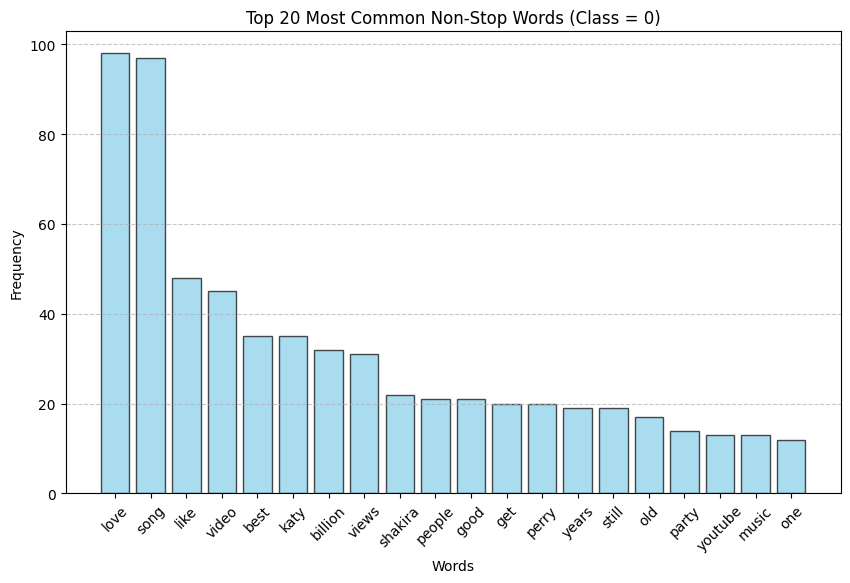

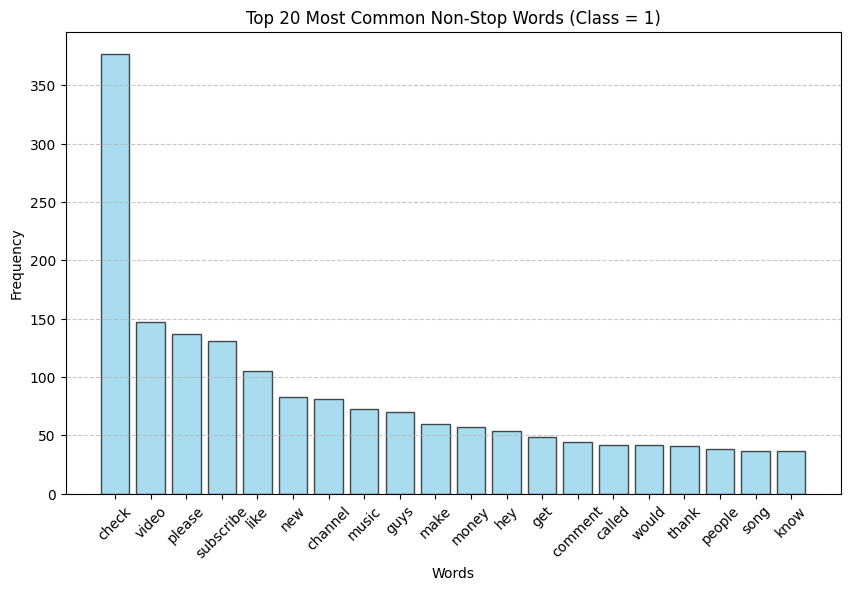

In [26]:


# Ensure you have the stopwords
nltk.download('stopwords')

# Define stop words for filtering
stop_words = set(stopwords.words('english'))

# Function to get non-stop words
def get_non_stop_words(content):
    words = content.split()
    non_stop_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return non_stop_words

# Function to get the most common words for a specific class
def get_most_common_words_by_class(df, class_label, n=20):
    class_df = df[df['CLASS'] == class_label]
    all_words = []
    class_df['CONTENT'].apply(lambda content: all_words.extend(get_non_stop_words(content)))
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get the top 20 words for CLASS = 0 and CLASS = 1
top_words_class_0 = get_most_common_words_by_class(df, class_label=0, n=20)
top_words_class_1 = get_most_common_words_by_class(df, class_label=1, n=20)

print("Top Words for Class 0:")
for word, count in top_words_class_0:
    print(f"{word}: {count}")

print("\nTop Words for Class 1:")
for word, count in top_words_class_1:
    print(f"{word}: {count}")

def plot_most_common_words(common_words, title):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue', edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_most_common_words(top_words_class_0, 'Top 20 Most Common Non-Stop Words (Class = 0)')
plot_most_common_words(top_words_class_1, 'Top 20 Most Common Non-Stop Words (Class = 1)')


We see that a lot of the non-spam comments have less frequent words for words like love, song, like, video, but the spam comments have really frequent words with check, video, please, subscribe.

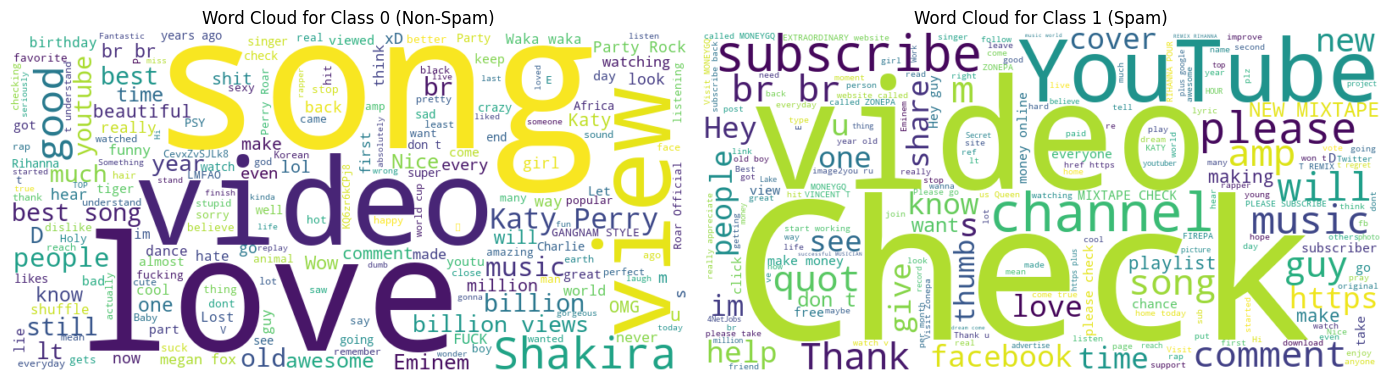

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# c0
class_0_text = " ".join(df[df['CLASS'] == 0]['CONTENT'].dropna())
wordcloud_class_0 = WordCloud(width=800, height=400, background_color="white").generate(class_0_text)

# Class 1
class_1_text = " ".join(df[df['CLASS'] == 1]['CONTENT'].dropna())
wordcloud_class_1 = WordCloud(width=800, height=400, background_color="white").generate(class_1_text)

# plot
plt.figure(figsize=(14, 7))

# Word Cloud for Class 0
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_class_0, interpolation='bilinear')
plt.title("Word Cloud for Class 0 (Non-Spam)")
plt.axis("off")

# Word Cloud for Class 1
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_class_1, interpolation='bilinear')
plt.title("Word Cloud for Class 1 (Spam)")
plt.axis("off")

plt.tight_layout()
plt.show()



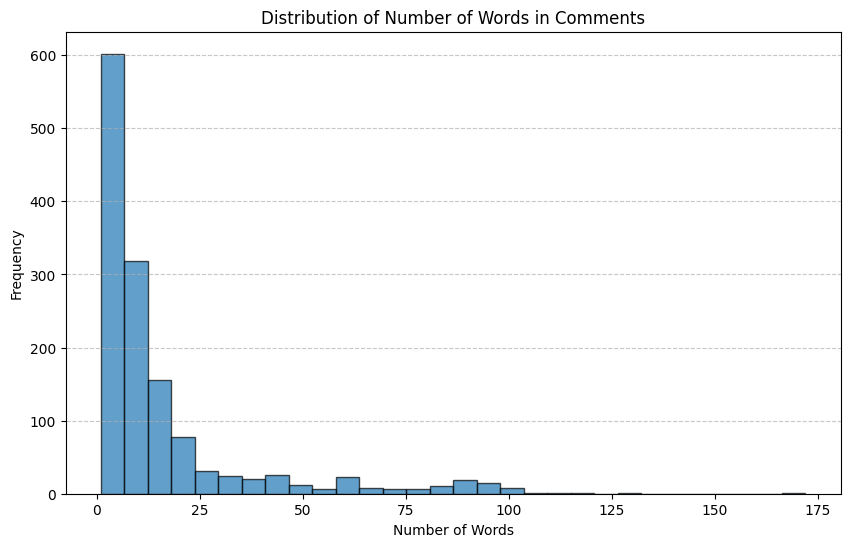

count    1369.000000
mean       15.829072
std        21.612720
min         1.000000
25%         4.000000
50%         7.000000
75%        16.000000
max       172.000000
Name: Word_Count, dtype: float64


In [28]:
df['Word_Count'] = df['CONTENT'].apply(lambda content: len(content.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['Word_Count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Number of Words in Comments')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(df['Word_Count'].describe())

The number of words per comment ranges from 1 to 172, with an average of approximately 16 words per comment. Half of the comments have 7 words or fewer, while the top 25% of comments contain 16 or more words. We have a skewed distribution here.

Let's also check out the most commented videos:

<Axes: title={'center': 'Top 10 Most Commented Videos'}, xlabel='VIDEO_NAME'>

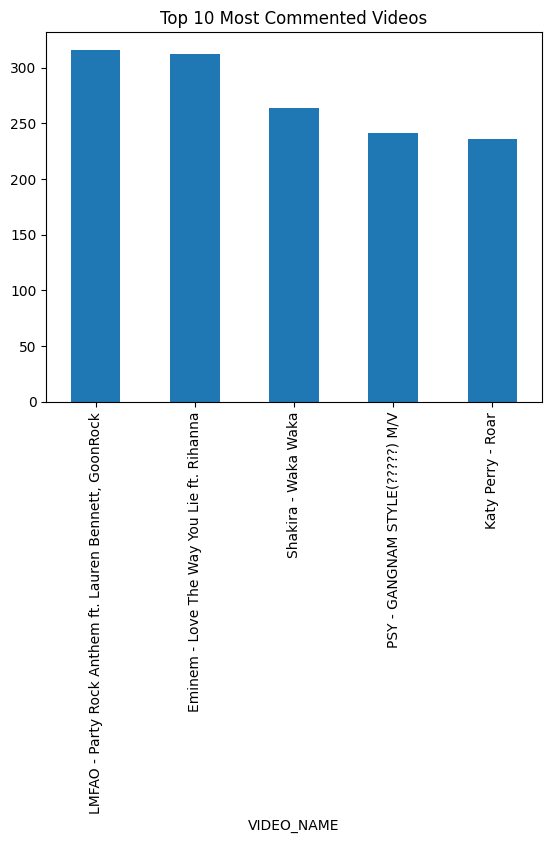

In [29]:
video_counts = df['VIDEO_NAME'].value_counts()
video_counts.head(10).plot(kind='bar', title='Top 10 Most Commented Videos')



We can also see the most common n-grams of comments:

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(df['CONTENT'])
ngram_counts = pd.DataFrame({'Ngram': vectorizer.get_feature_names_out(), 'Count': X.sum(axis=0).tolist()[0]})
ngram_counts = ngram_counts.sort_values(by='Count', ascending=False)
print(ngram_counts.head(10))


                     Ngram  Count
3112           check video     99
14238        video youtube     99
3118   check video youtube     89
2233                 br br     83
3025             check new     52
6783              http www     46
2238              br br br     44
8610             love song     37
6836             https www     35
9316           moneygq com     33


Lastly, we see that there is a lot of frequent n-grams such as video youtube and check video. Others such as http www and https www are most likely URLS, from spam.

Let's also see the average similarity of the words in non-spam, vs the average similarity of the words in the spam categories.

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

def train_word2vec(corpus):
    tokenized = [sentence.split() for sentence in corpus]
    model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4)
    return model

def calculate_average_similarity(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) < 2:
        return 0  # Not enough words for comparison
    similarities = cosine_similarity(word_vectors)
    upper_triangle = np.triu_indices(similarities.shape[0], k=1)
    avg_similarity = similarities[upper_triangle].mean()
    return avg_similarity

# Get class-specific texts and train Word2Vec
class_0_words = " ".join(df[df['CLASS'] == 0]['CONTENT']).split()
class_1_words = " ".join(df[df['CLASS'] == 1]['CONTENT']).split()

# Train Word2Vec models
class_0_model = train_word2vec(df[df['CLASS'] == 0]['CONTENT'])
class_1_model = train_word2vec(df[df['CLASS'] == 1]['CONTENT'])

# Calculate average similarities
class_0_similarity = calculate_average_similarity(class_0_words, class_0_model)
class_1_similarity = calculate_average_similarity(class_1_words, class_1_model)

print(f"Average Similarity (Class 0): {class_0_similarity:.4f}")
print(f"Average Similarity (Class 1): {class_1_similarity:.4f}")



After training a Word2Vec model, and adjusting for cosine similarity, we can see that a lot fo the spam comments are very similar to each other, with a 0.6453 average similarity, while the average similarity within non-spam words are very small: 0.0749

Finally, we fit a very simple benchmark model, where if the comment has the words `check`, `please`, `subscribe`, and `like`, then we classify it as spam

In [ ]:
target_words = ['check', 'please', 'subscribe', 'like']

for word in target_words:
    df[f'HAS_{word.upper()}'] = df['CONTENT'].dropna().apply(lambda x: 1 if word in x.lower() else 0)

word_class_relationship = df.groupby('CLASS')[[f'HAS_{word.upper()}' for word in target_words]].mean()

for word in target_words:
    correlation = df[f'HAS_{word.upper()}'].corr(df['CLASS'])
    print(f"Correlation between the presence of '{word}' and CLASS: {correlation:.4f}")


Correlation between the presence of 'check' and CLASS: 0.5322
Correlation between the presence of 'please' and CLASS: 0.3071
Correlation between the presence of 'subscribe' and CLASS: 0.3557
Correlation between the presence of 'like' and CLASS: 0.0569


We see that `check`, `subscribe` and `please` are highly correlated with spam words.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

target_words = ['check', 'please', 'subscribe', 'like']

df['HAS_TARGET_WORD'] = df['CONTENT'].dropna().apply(
    lambda x: 1 if any(word in x.lower() for word in target_words) else 0
)

X = df['HAS_TARGET_WORD'].values.reshape(-1, 1)
y = df['CLASS'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       145
           1       0.85      0.79      0.82       129

    accuracy                           0.84       274
   macro avg       0.84      0.83      0.83       274
weighted avg       0.84      0.84      0.84       274



We get a `0.84` accuracy by predicting if the class has those target words! (would this be bad statistical practice)



#### Data Cleaning

**Stop Words**

Stop words are typically the most frequently used words in a language and aare generally considered to have little semantic meaning in the conect of text analysic. These words rare often removed from text data during preprocessing because they can introduce noise without constributing significant information about the content or meaning of the text. Examples in English include "the", "is", "in", "at", "which", "and", etc. Many stop words are function words, which serve a grammatical purpose rather than conveying meaning. They help in structuring sentences but do not provide much insight into the topic or sentiment of the text.

By removing the stop words, the size of the vocabulary is reduced. We try to focus on words that carry important information, such as nouns, verbs, adjectives, and adverbs. By reducing the feature space of the model, we decrease the complexity and improve their performance. See below for a list of stop words.

In [ ]:
# Display the stop words used
# nltk.download('stopwords')
stop_words = stopwords.words('english')
print(f" Stop words used: \n", stop_words)


 Stop words used: 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sa


The process involved in data cleaning for our model:
1. First, we converted all the words into lower-case letters.
2. We experimented with removal of links, for example words starting with "http", "www", "https". We decided to keep these words as these features deemed to be signficant in model prediction.
3. We removed all non-ASCII characters.
4. We removed any characters that is not an alphabet, a digit, or a whitespace.
5. We removed whitespace characters such as spaces, tabs, and new lines.
6. We removed any digit, equivalent to `[0-9]`.
7. We removed any trailing whitespace characters from a string either at the beginning or at the end of the sentences.




#### Feature Selection

##### Vectorizing features
**TF-IDF vectorizer**
Put the math behind tf-idf vectorizer here..

**Bag of Words**
Explain BOW method..

**Word-to-vec vectorzer**
Explain word-to-vec model here..

**Features**

The process described above on data-cleaning, and then converting words into tokens can be performed with a library called `TfidfVectorizer`, with a single line: \
` feature_extraction = TfidfVectorizer(min_df = 2, stop_words = 'english', lowercase = True) `

Here, `min_df = 2` removes words that appear in less than 2 sentences. \
`stop_words = english` uses the same process for data cleaning as described in the data cleaning section above.\
This function returns a feature model that can then be used to get tokens from our traning dataset. This process results in a total of 884 features for our training dataset.

These parameters were chosen to give us the most simplistic model yet achieving highest performance.



### Result and Conclusion

For this classification problem, both Binary Logistic Regression and Support Vector Machine are valid models to train and predict the datasets on. Both models try to draw a hyperplane that separates the two classes, however Logistic Regression is a linear model, and SVM allows non-linear relationships between features and the binary outcome. 

### Discussion

### References

### Code

#### Data Cleaning
**Stop Words**


In [ ]:
# Import libraries

import nltk
from nltk.corpus import stopwords